# Export

In [11]:
import datetime
import os
from dataclasses import dataclass
from typing import Any, Dict, Tuple

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [77]:
path = "../logs/train/runs/2025-03-10_20-00-34/Common Buzzard/csv/version_0/Common_Buzzard.nc"
data = xr.open_dataset(path)

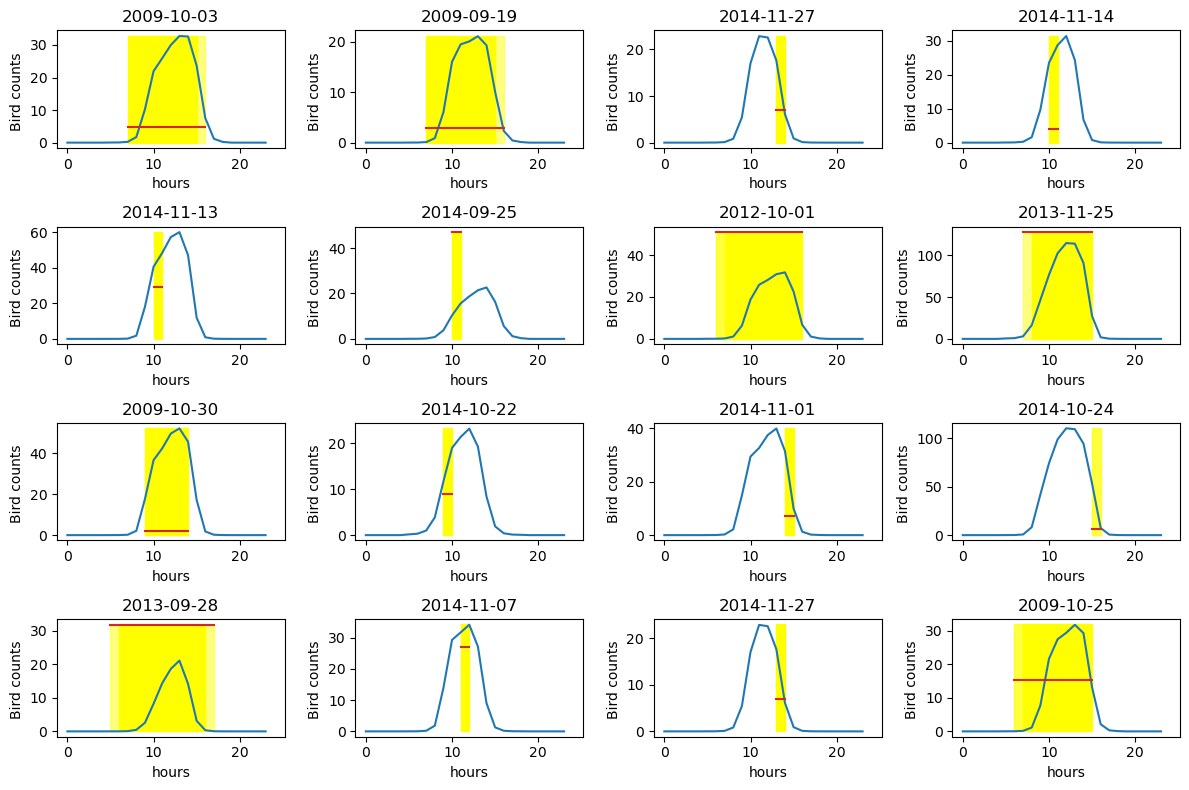

In [51]:
def plt_timeseries(data, log_transformed=False):

    _, ax = plt.subplots(4, 4, figsize=(12, 8), tight_layout=True)
    ax = ax.flatten()

    # Sample indices proportionally to weights sum of estimated counts per date
    valid_indices = np.where(data.obs_count > 0)[0]
    weights = data.pred_log_hourly_count[valid_indices].sum(dim="time").values
    sampled_indices = np.random.choice(
        valid_indices, size=16, p=weights / weights.sum()
    )

    for i, d in enumerate(sampled_indices):
        # Select data for this day
        subs = data.isel(date=d)

        if log_transformed:
            obs = np.log1p(subs["obs_count"])
            pred = subs["pred_log_hourly_count"]
        else:
            obs = subs["obs_count"]
            pred = np.expm1(subs["pred_log_hourly_count"])

        # Plot the prediction (blue line)
        ax[i].plot(np.arange(0, 24), pred)

        ymax = max(pred.max(), obs) + 0.1

        # Plot the mask as yellow transparant background
        for k, m in enumerate(subs.mask.values):
            ax[i].add_patch(
                Rectangle((k, 0), 1, ymax, color=(1, 1, 0, m))
            )  # RGBA: (1, 1, 0) is yellow, 'm' controls the alpha

        first_nonzero = np.argmax(subs.mask.values > 0)
        last_nonzero = (
            len(subs.mask.values) - 1 - np.argmax(np.flip(subs.mask.values) > 0)
        )

        ax[i].plot([first_nonzero, last_nonzero + 1], [obs, obs], c="tab:red")

        # ax[i].set_ylim(0, ymax)
        ax[i].set_xlabel("hours")
        ax[i].set_ylabel(f"Bird counts {'(transform)' if log_transformed else ''}")
        ax[i].set_title(data.isel(date=d).date.dt.strftime("%Y-%m-%d").item())
    # fig.savefig(f"{self.plotdir}/timeseries.jpg")
    # plt.close()


plt_timeseries(data, log_transformed=False)

In [87]:
data

<xarray.Dataset>
Dimensions:                            (date: 1514, time: 24, location: 1)
Coordinates:
  * date                               (date) datetime64[ns] 1978-07-28 ... 2...
  * time                               (time) object '0 nanoseconds' ... '828...
  * location                           (location) object 'Defile'
Data variables: (12/20)
    temperature_2m                     (date, time, location) float64 ...
    dewpoint_temperature_2m            (date, time, location) float64 ...
    total_precipitation                (date, time, location) float64 ...
    surface_pressure                   (date, time, location) float64 ...
    u_component_of_wind_10m            (date, time, location) float64 ...
    v_component_of_wind_10m            (date, time, location) float64 ...
    ...                                 ...
    sun_altitude                       (date, time, location) float64 ...
    sun_azimuth                        (date, time, location) float64 ...
    pred_log_hourly_count              (date, time) float32 ...
    mask                               (date, time) float32 ...
    obs_count                          (date) float32 ...
    pred_count                         (date) float32 ...

In [103]:
data_df

,obs_count,pred_count
date,,
1978-07-28,0.0,0.001952
1978-07-29,0.0,0.001841
1978-07-30,0.0,0.003586
1978-08-03,0.0,0.024595
1978-08-06,0.0,0.006063
...,...,...
2014-11-21,0.0,7.803698
2014-11-22,0.0,0.094893
2014-11-24,0.0,6.499412


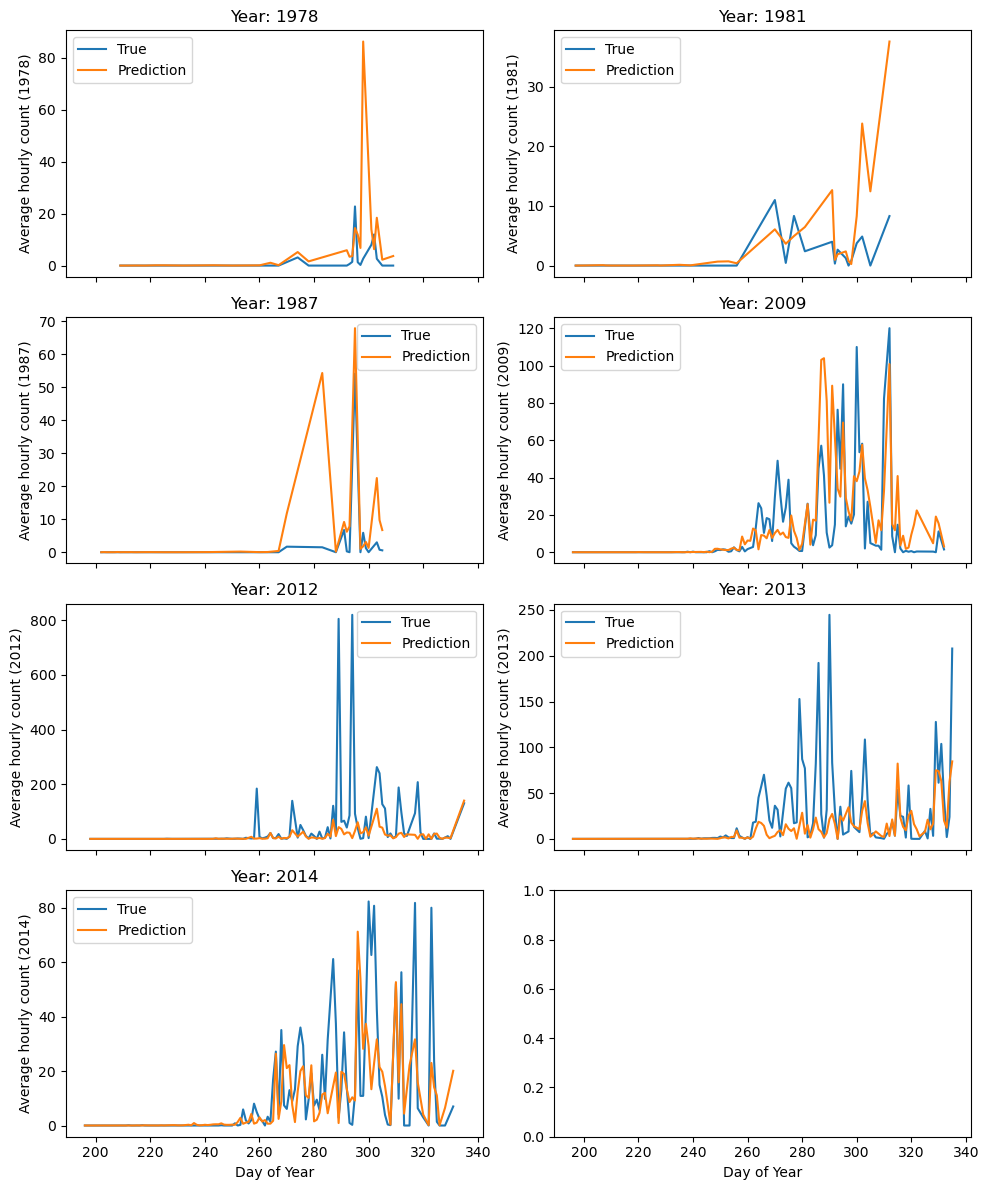

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
pred_count = np.expm1(data.pred_log_hourly_count)

In [124]:
subset.values

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00425179, 0.00157129, 0.00146304, 0.00253652, 0.00514945,
       0.00865938, 0.01140802, 0.0131373 , 0.01454738, 0.0151508 ,
       0.0135566 , 0.01039294, 0.00799637, 0.00833095, 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

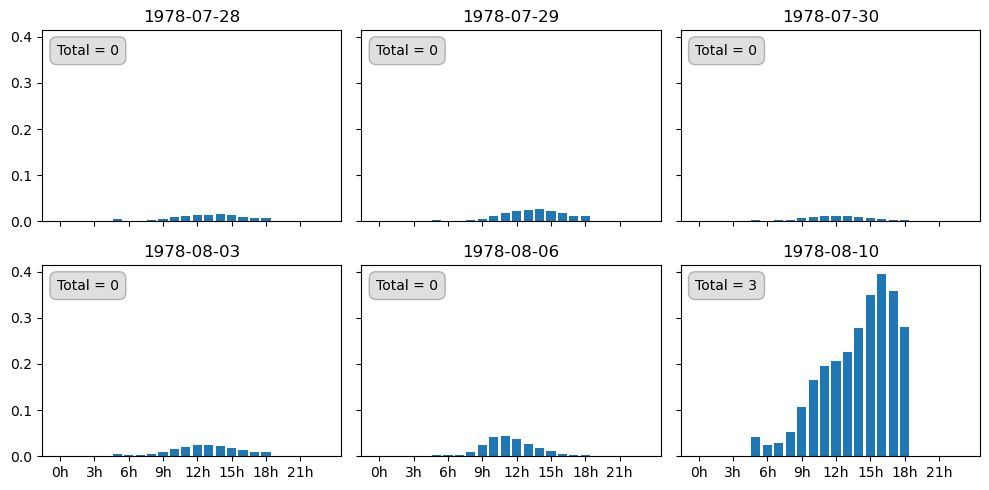

In [126]:
fig, ax = plt.subplots(
    2, 3, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True
)
ax = ax.flatten()
for k in range(6):#len(pred_count.date)):
    subset = pred_count.isel(date=k)

    ax[k].bar(np.arange(24), subset.values)

    ax[k].set_title(subset.date.dt.strftime("%Y-%m-%d").item())
    ax[k].set_xticks(np.arange(0, 24, 3), [str(h) + "h" for h in np.arange(0, 24, 3)])

    ax[k].text(
        0.05,
        0.93,
        f"Total = {np.sum(subset.values):.0f}",
        transform=ax[k].transAxes,
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="gray", alpha=0.25),
    )

In [ ]:
data.sum(dim="time").estimated_hourly_counts.plot()
plt.show()

In [ ]:
path = r"C:\Users\amedee.roy\OneDrive - FRANCE ENERGIES MARINES\SCRIPTS\defile-migration-forecast\logs\train\runs\2024-07-16_11-03-35\test_pred.nc"
data = xr.open_dataset(path)
data = data.assign_coords(year=data["date"].dt.year)

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

fig, ax = plt.subplots(2, 3, figsize=(15, 6), tight_layout=True)
ax = ax.flatten()
for k, year in enumerate(np.unique(data.year)):

    sub = data.where(data.year == year, drop=True)
    sub = sub.groupby("date").mean()

    sub.masked_total_counts.plot(ax=ax[k], label="True")
    sub.estimated_masked_total_counts.plot(ax=ax[k], label="Prediction")

    score = r2_score(sub.masked_total_counts, sub.estimated_masked_total_counts)
    coeff = pearsonr(sub.masked_total_counts, sub.estimated_masked_total_counts)

    ax[k].annotate(
        rf"R$^2$ = {score:.2f}" + "\n" + rf"$\rho$ = {coeff.statistic:.2f}",
        xy=(0.05, 0.7),
        xycoords="axes fraction",
        bbox=dict(facecolor="grey", alpha=0.3),
    )

    ax[k].set_title(year)

plt.legend()
plt.show()

In [ ]:
subs

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 8), tight_layout=True)
ax = ax.flatten()
for i, k in enumerate(np.random.randint(0, len(data.date), size=16)):
    subs = data.isel(date=k)
    ax[i].plot(np.arange(0, 24), subs.estimated_hourly_counts)
    ax[i].plot(np.arange(0, 24), subs.temperature_2m / 10)

In [ ]:
# path = r"C:\Users\amedee.roy\OneDrive - FRANCE ENERGIES MARINES\SCRIPTS\defile-migration-forecast\data\all_count_processed.csv"
# data = pd.read_csv(path, parse_dates=["date", "start", "end"])
# data['year'] = data['date'].dt.year
# data['obs_time'] = (data['end'] - data['start']).dt.seconds/3600
# data_demo = data.groupby(["year", "species"]).sum(numeric_only=True)
# data_demo['rel_count'] = data_demo['count'] / data_demo['obs_time']
# data_demo = data_demo.reset_index()

In [ ]:
# species = ["Milan noir", "Common Buzzard", "Bondrée apivore",
#             "Milan royal", "Épervier d'Europe", "Faucon crécerelle",
#             "Balbuzard pêcheur", "Faucon hobereau", "Busard Saint-Martin",
#             "Faucon émerillon", "Busard cendré", "Circaète Jean-le-Blanc"]

# fig, ax = plt.subplots(4,3, figsize=(12,8), tight_layout=True)
# ax = ax.flatten()
# for k, sp in enumerate(species):
#     sub = data_demo[data_demo.species == sp].copy()

#     x = np.linspace(min(sub.year), max(sub.year), 100)
#     coef = np.polyfit(sub.year, sub.rel_count, 5)
#     y = np.polyval(coef, x)

#     ax[k].plot(sub.year, sub.rel_count)
#     ax[k].plot(x, y)
#     ax[k].set_title(sp)

## Global metric


In [ ]:
true_count = data.masked_total_counts.values
pred_count = data.estimated_masked_total_counts.values

plt.hist(true_count, label="True count", alpha=0.5)
plt.hist(pred_count, label="Predicted count", alpha=0.5)
plt.xlabel("Count (log-scale)")
plt.ylabel("Histogram")
plt.legend()
plt.show()

In [ ]:
x = np.linspace(min(true_count), max(true_count), 100)
coef = np.polyfit(true_count, pred_count, 5)
y = np.polyval(coef, x)

plt.scatter(true_count, pred_count, c="black", s=5, alpha=0.4)
plt.plot(x, y, c="red")
plt.plot(x, x, "--", c="black")
plt.xlabel("True count (log-scale)")
plt.ylabel("Predicted count (log-scale)")
plt.show()

## Timeseries


In [ ]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(4, 4, figsize=(12, 8), tight_layout=True)
ax = ax.flatten()
for i, k in enumerate(np.random.randint(0, len(data.date), size=16)):
    subs = data.isel(date=k)

    ax[i].plot(np.arange(0, 24), subs.estimated_hourly_counts)
    for k, m in enumerate(subs.mask.values):
        if m == 1:
            ax[i].add_patch(Rectangle((k, 0), m, 10, color="yellow"))
            obs = subs.masked_total_counts.item() / subs.mask.sum().item()
            ax[i].plot([k, k + 1], [obs, obs], c="tab:red")

    ax[i].set_ylim(0, max(subs.estimated_hourly_counts.max(), obs) + 0.1)
    ax[i].set_xlabel("hours")
    ax[i].set_ylabel("Bird counts (log10)")
# plt.savefig(f'{self.plotdir}/plt_timeseries.jpg')

In [ ]:
data = data.assign_coords(doy=data.date.dt.dayofyear)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
data.groupby("doy").sum().masked_total_counts.plot(ax=ax, label="True")
data.groupby("doy").sum().estimated_masked_total_counts.plot(ax=ax, label="Prediction")
plt.legend()
plt.show()